# Introduction

We will be looking at a dataset of over 50,000 used vehicles advertised in 2018-2019. We will load, clean, and hydrate the data before moving on to some basic statistics. These statistics will then guide some exploratory data analysis comparing such metrics as price, car make and model, and age of vehicle.

## Initializing

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import math as mt
import plotly.express as px
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter as scf


## First Looks at Vehicle Data

In [2]:
# Load dataset into dataframe
df = pd.read_csv('../vehicles_us.csv')

The only dataset we are looking at is stored under 'vehicles_us.csv,' which has 51,525 entries on car data.

In [3]:
# Basic Info 
print(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB
None


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


## Cleaning Vehicle Data

There is a 'date_posted' column we should convert to datetime. 

In [4]:
# Convert to datetime
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d')

Additionally, there are some NaN entries for 'model_year,' 'cylinders,' 'odometer,' 'paint_color', and 'is_4wd' but we should only replace these for categorical data as for the quantitative columns NaNs are meaningful data points. We will therefore only clean up the 'paint_color' and 'is_4wd' columns.

In [5]:
# Demonstrating values of 'is_4wd' column
display(df['is_4wd'].unique())

array([ 1., nan])

 The 'is_4wd' column only has values of 1.0 and NaN, so NaN values must indicate that the vehicle is not 4-wheel-drive.

In [6]:
# Wipe NaNs from paint color column
df['paint_color'] = df['paint_color'].fillna('Unknown')

# Wipe NaNs from 4WD column and Unify the boolean values  
df['is_4wd'] = df['is_4wd'].astype('str')
df['is_4wd'] = df['is_4wd'].where(df['is_4wd'] != 'nan', 'No')
df['is_4wd'] = df['is_4wd'].where(df['is_4wd'] != '1.0', 'Yes')
display(df['is_4wd'].value_counts())

is_4wd
No     25953
Yes    25572
Name: count, dtype: int64

Now we will check for dupicate row entries.

In [7]:
# Check for duplicates
dup = df[df.duplicated()]

if len(dup) >= 1:
    display(dup)
else:
    print('There are no duplicate rows.')

There are no duplicate rows.


## Basic Stats

We'll grab a couple basic pieces of information before anything else.

In [8]:
# What years were the advertisements placed?
display(df['date_posted'].dt.year.unique())

array([2018, 2019])

In [9]:
# What is the distribution of automatic versus manual transmission?
display(df['transmission'].value_counts())

transmission
automatic    46902
manual        2829
other         1794
Name: count, dtype: int64

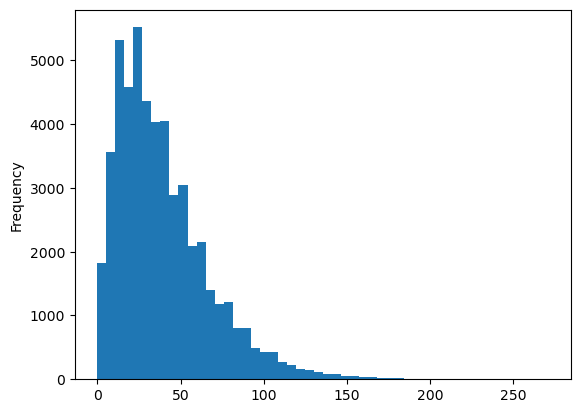

In [10]:
# Days listed overall distribution -- No fancy labels or editing
df['days_listed'].plot(kind='hist', bins=50)
plt.show()

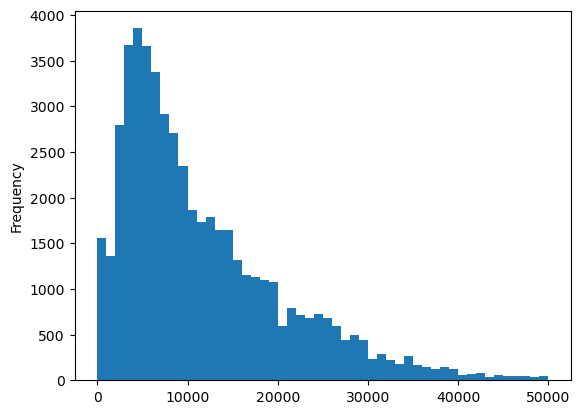

In [11]:
# Price overall distribution -- No fancy labels or editing
df.query("price < 50000")['price'].plot(kind='hist', bins=50)
plt.show()

## Feature Generation

Any additional data that will be required in the below analysis will be put here.

In [12]:
# We'll calculate the approximate vehicle age by subtracting the year it was posted from the model year of the car.
df['vehicle_age'] = df['date_posted'].dt.year - df['model_year']

# Summary Analysis

## Correlation Matrix

In [13]:
# Correlation matrix. We are especially interested in the final column 'days_listed' as this could be an important dependent variable
num_only_df = df.loc[:, ['price', 'model_year', 'cylinders', 'odometer', 'days_listed', 'vehicle_age']]
display(num_only_df.corr())

,price,model_year,cylinders,odometer,days_listed,vehicle_age
price,1.000000,0.428656,0.296627,-0.420299,-0.000682,-0.427448
model_year,0.428656,1.000000,-0.148040,-0.473948,-0.005703,-0.997310
cylinders,0.296627,-0.148040,1.000000,0.090160,0.005517,0.147848
odometer,-0.420299,-0.473948,0.090160,1.000000,0.003804,0.472367
days_listed,-0.000682,-0.005703,0.005517,0.003804,1.000000,0.006422
vehicle_age,-0.427448,-0.997310,0.147848,0.472367,0.006422,1.000000


Unfortunately, the 'days_listed' appears to have positively nothing to do with the other variables. 'Price,' 'odometer,' and 'vehicle_age' are the more interesting factors.

## Vehicle Age and Odometer 

It is reasonable to expect that the older a car is, the more it has been driven, and thus the more likely the odometer has been run up.

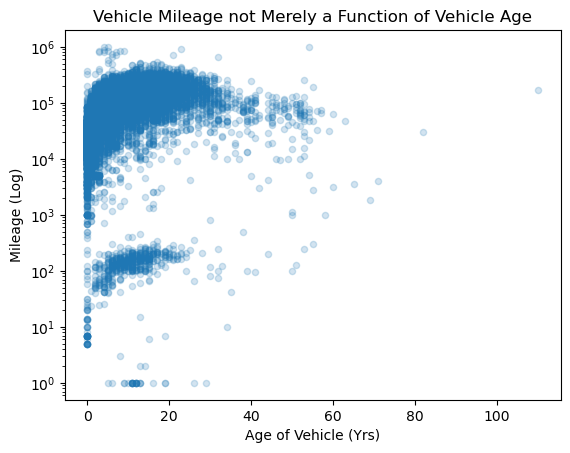

'The correlation coefficient between vehicle age and odometer mileage is 0.47236741007651023.'

In [14]:
# Relating vehicle age to odometer. We should expect something of a linear relationship
df.plot(x='vehicle_age', y='odometer', kind='scatter', alpha=0.2)

# Log-scale to better see distribution at low end. Add labels
plt.yscale('log')
plt.title('Vehicle Mileage a Mildly Linear Function of Vehicle Age')
plt.xlabel('Age of Vehicle (Yrs)')
plt.ylabel('Mileage (Log)')
plt.show()

# Calculate correlation
age_vs_mileage_corr = df['vehicle_age'].corr(df['odometer'])
display(f'The correlation coefficient between vehicle age and odometer mileage is {age_vs_mileage_corr}.')

We can see that the correlation between vehicle age and odometer mileage is less than 0.5, which indicates a mild correlation. We also know that these are used cars. It could be theorized that in the whole population of vehicles, the relationship between age and mileage could be stronger, but here, cars tend to only be put on the used car market at a certain point in their life cycle. This is why we see rather few cars with mileage between 300 and 40,000 miles. The cloud of hundreds of data points in the 50 miles to 300 miles range seems to indicate that some new vehicles are not good fits for their new owners, or are simply resold.

## Price

The most valuable dependent variable in the dataset is price. All factors combine to contribute to the price -- this is why there are many columns with a mild to moderate correlation of around 0.5 or -0.5 against price. 

In [19]:
# Histogram of price information. For visual purposes, limit to 50000
px.histogram(
    df.query("price < 50000"),
    x='price', 
    nbins=50,
    color='condition',
    title='Price by Condition',
    histnorm='percent',
    barmode='overlay'
)

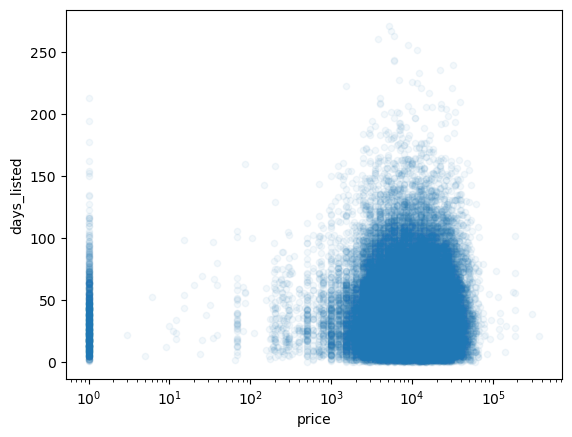

'The correlation coefficient between price and days listed is -0.0006821100678298549'

In [16]:
# Compare price to days on market. If the prices are too high relative to the real value of the vehicle, they should take longer to sell
df.plot(x='price', y='days_listed', kind='scatter', alpha=0.05)
plt.xscale('log')
plt.show()

# Calculate correlation
price_vs_listed_corr = df['price'].corr(df['days_listed'])
display(f'The correlation coefficient between price and days listed is {price_vs_listed_corr}')

Because there is no relationship between the length of time being advertised and the price (unlike other markets like, say, the housing market) we might reasonably conclude the prices are fair.